# Predicción de Precios en bolsa MSCI

El objetivo de este proyecto es desarrollar un modelo basado en redes neuronales recurrentes (LSTM) para predecir los precios futuros de acciones, en este caso MSCI World, utilizando los datos del histórico de mercado en apertura, cierre, máximo y mínimo.

Con este proyecto se prodía ayudar en la toma de decisiones de inversión y análisis.

A continuación vamos a instalar las librerías necesarias para nuestro proyecto


In [ ]:
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 🔒 Desactiva GPU

In [1]:
import tensorflow as tf
print("Dispositivo:", tf.config.list_physical_devices())

Dispositivo: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date
from sklearn.preprocessing import MinMaxScaler


# Cargamos y leemos los datos
Vamos a cargar los valores de la acción en bolsa con precios de apertura, cierre, alto y bajo...

La fuente de los datos viene de Yahoo Finance y haremos la predicción en base a los datos que tenemos desde 2022.

In [4]:
ticker = ["MSCI"]
start_date = "2022-01-01"
today = date.today().strftime("%Y-%m-%d")

# Descargo los datos
data = yf.download(ticker, start=start_date, end=today)
data = data.dropna()  # Elimino nulos, días sin datos
print(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open  Volume
Ticker            MSCI        MSCI        MSCI        MSCI    MSCI
Date                                                              
2022-01-03  573.252502  593.994609  566.919162  591.299590  297500
2022-01-04  568.969360  583.589911  562.135553  582.482999  381800
2022-01-05  544.896973  569.643163  544.021113  568.054996  548400
2022-01-06  541.874634  544.781437  529.592979  541.508875  705600
2022-01-07  531.306274  544.945044  530.998264  541.874630  551600
...                ...         ...         ...         ...     ...
2025-06-04  566.909973  569.729980  565.349976  568.190002  264600
2025-06-05  564.070007  568.929993  561.150024  568.929993  348300
2025-06-06  568.640015  569.750000  564.559998  566.400024  251300
2025-06-09  558.000000  569.219971  557.299988  567.780029  526500
2025-06-10  557.840027  563.260010  556.090027  558.960022  500400

[862 rows x 5 columns]


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862 entries, 2022-01-03 to 2025-06-10
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MSCI)   862 non-null    float64
 1   (High, MSCI)    862 non-null    float64
 2   (Low, MSCI)     862 non-null    float64
 3   (Open, MSCI)    862 non-null    float64
 4   (Volume, MSCI)  862 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 40.4 KB
None


In [6]:
# Usar solo columnas 'Close' y 'Open'
data = data[['Close']].copy()

In [7]:
print("Primeros 5 elementos del dataset", end = "\n")
print(data.head(5))
print("Ultimos 5 elementos del dataset", end = "\n")
print(data.tail(5))

Primeros 5 elementos del dataset
Price            Close
Ticker            MSCI
Date                  
2022-01-03  573.252502
2022-01-04  568.969360
2022-01-05  544.896973
2022-01-06  541.874634
2022-01-07  531.306274
Ultimos 5 elementos del dataset
Price            Close
Ticker            MSCI
Date                  
2025-06-04  566.909973
2025-06-05  564.070007
2025-06-06  568.640015
2025-06-09  558.000000
2025-06-10  557.840027


Hacemos una pequeña exploración y ordenamos los datos del más antiguo al más reciente

In [8]:
df = data.sort_values(by="Date")
print(df.head())

Price            Close
Ticker            MSCI
Date                  
2022-01-03  573.252502
2022-01-04  568.969360
2022-01-05  544.896973
2022-01-06  541.874634
2022-01-07  531.306274


# Escaldo de datos
Transformaremos los valores que tenemos con MinMaxScaler para que esten en escalas comparables

In [9]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
print(price[:5])

Price            Close
Ticker            MSCI
Date                  
2022-01-03  573.252502
2022-01-04  568.969360
2022-01-05  544.896973
2022-01-06  541.874634
2022-01-07  531.306274


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_price = scaler.fit_transform(price.values)
y_price = scaler.fit_transform(price.values)

print(x_price[:5])

[[0.77948393]
 [0.76340837]
 [0.67305951]
 [0.66171602]
 [0.62205069]]


# Conjunto de Test y Training
Ahora vamos a crear el conjunto de datos de Test y Training, tras hacer unas pruebas, lo haremos con una ventana de entrenamiento de 15.



In [11]:
train_window = 10
import numpy as np

def create_in_out_sequences(price, tw):
    inout_seq = []
    L = len(x_price)
    print('Length = ', L)

    for i in range(L - tw):
        data_seq = x_price[i:i + tw]
        data_label = price[i + tw:i + tw + 1][0]
        inout_seq.append((data_seq, data_label))

    data = inout_seq
    print('Total data size:', len(data))

    # Calcular el tamaño del conjunto de entrenamiento como el 70%
    train_set_size = int(len(data) * 0.7)
    test_set_size = len(data) - train_set_size

    print('Train size:', train_set_size)
    print('Test size:', test_set_size)

    train = data[:train_set_size]
    test = data[train_set_size:]

    # Opcional: recorte para evitar problemas si haces series temporales con ventanas
    train = train[:-(tw - 1)] if len(train) > (tw - 1) else train

    return train, test

train, test = create_in_out_sequences(x_price, train_window)


Length =  862
Total data size: 852
Train size: 596
Test size: 256


In [12]:
print(test[0])
print(train[-1])

(array([[0.50236048],
       [0.52806602],
       [0.50310246],
       [0.49679663],
       [0.44698096],
       [0.45662492],
       [0.46664022],
       [0.4445328 ],
       [0.44371671],
       [0.46471138]]), array([0.44735173]))
(array([[0.35467578],
       [0.38591676],
       [0.37079543],
       [0.36839229],
       [0.4118342 ],
       [0.42166875],
       [0.42318444],
       [0.43257527],
       [0.43978493],
       [0.47335404]]), array([0.50236048]))


Construimos nuestro modelo con la implementación de una red LSTM en PyTorch con una capa oculta de tamaño 100 y una capa lineal para la salida.

In [13]:
x_train = []
y_train = []

for i in range(100, price.shape[0]):
    x_train.append(x_price[i-100: i])
    y_train.append(x_price[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [14]:
print(x_train.shape)
print(y_train.shape)

(762, 100, 1)
(762,)


In [15]:
x_test = []
y_test = []

for i in range(100, price.shape[0]):
   x_test.append(y_price[i-100: i])
   y_test.append(y_price[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)


In [16]:
print(x_test.shape)
print(y_test.shape)


(762, 100, 1)
(762,)


In [17]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [18]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])
model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs = 50)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - MAE: 0.3731 - loss: 0.1943 - val_MAE: 0.0993 - val_loss: 0.0157
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - MAE: 0.1351 - loss: 0.0279 - val_MAE: 0.0978 - val_loss: 0.0146
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - MAE: 0.1195 - loss: 0.0225 - val_MAE: 0.0835 - val_loss: 0.0115
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - MAE: 0.1124 - loss: 0.0198 - val_MAE: 0.1184 - val_loss: 0.0191
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 386ms/step - MAE: 0.1117 - loss: 0.0204 - val_MAE: 0.0817 - val_loss: 0.0107
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - MAE: 0.1056 - loss: 0.0177 - val_MAE: 0.0885 - val_loss: 0.0118
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step - MAE: 0.1085 - loss: 0.0174 - val_MAE: 0.0807 - val_loss: 0.0102
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step - MAE: 0.1051 - loss: 0.0174 - val_MAE: 0.0799 - val_loss: 0.0100
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/s

In [22]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(762, 100, 1)
(762,)
(762, 100, 1)
(762,)


In [23]:
x_test

array([[[0.77948393],
        [0.76340837],
        [0.67305951],
        ...,
        [0.14377961],
        [0.13263805],
        [0.1405858 ]],

       [[0.76340837],
        [0.67305951],
        [0.66171602],
        ...,
        [0.13263805],
        [0.1405858 ],
        [0.19858013]],

       [[0.67305951],
        [0.66171602],
        [0.62205069],
        ...,
        [0.1405858 ],
        [0.19858013],
        [0.25443326]],

       ...,

       [[0.79311316],
        [0.81280586],
        [0.86949764],
        ...,
        [0.75380244],
        [0.75567905],
        [0.74502004]],

       [[0.81280586],
        [0.86949764],
        [0.9029529 ],
        ...,
        [0.75567905],
        [0.74502004],
        [0.76217227]],

       [[0.86949764],
        [0.9029529 ],
        [0.91059907],
        ...,
        [0.74502004],
        [0.76217227],
        [0.722238  ]]])

In [24]:
y_pred = model.predict(x_test)
#y_pred_final = scaler.inverse_transform(y_pred)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


In [ ]:
y_pred.shape

(762, 1)

In [27]:
y_pred

array([[0.19966353],
       [0.19873632],
       [0.19814871],
       [0.19797723],
       [0.19840555],
       [0.20001344],
       [0.20299724],
       [0.2072239 ],
       [0.21252866],
       [0.21840385],
       [0.22404538],
       [0.22834288],
       [0.23032878],
       [0.22997616],
       [0.22791426],
       [0.2248778 ],
       [0.22139722],
       [0.2178278 ],
       [0.2144054 ],
       [0.21126859],
       [0.2084962 ],
       [0.20613332],
       [0.20417164],
       [0.20258054],
       [0.20130445],
       [0.2002937 ],
       [0.19951168],
       [0.19894095],
       [0.1985845 ],
       [0.19847628],
       [0.19865705],
       [0.19909422],
       [0.199603  ],
       [0.20001574],
       [0.20026894],
       [0.2003483 ],
       [0.20030572],
       [0.20022757],
       [0.20028095],
       [0.2007588 ],
       [0.20196994],
       [0.20416194],
       [0.2076746 ],
       [0.21326347],
       [0.2217309 ],
       [0.23329026],
       [0.24761856],
       [0.264

In [25]:
scaler.scale_

array([0.00375322])

In [26]:
scale_factor = 1/0.00375322
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

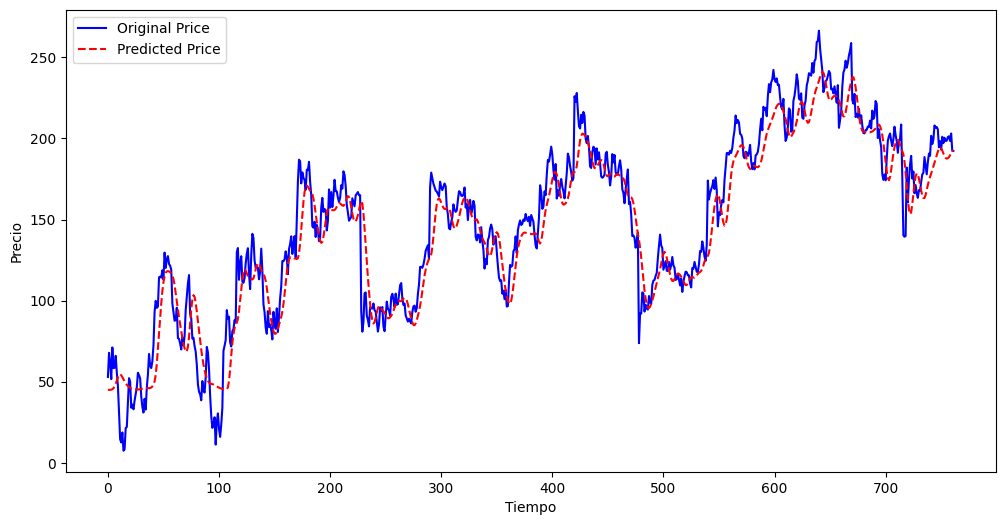

In [28]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price", linestyle='--')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

Entrenamiento por varias épocas, observando la reducción de la pérdida en lo conjuntos para evitar sobreajuste.

# Evaluación del modelo

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual = y_test
predicted = y_pred

mae = mean_absolute_error(actual, predicted)
print("Mean Absolute Error (MAE):", mae)

rmse = np.sqrt(mean_squared_error(actual, predicted))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 13.327940551480117
Root Mean Squared Error (RMSE): 17.381727905606024


# Mean Absolute Error (MAE) = 13.33
El modelo se equivoca en 13.33 unidades del precio al predecir.

Considerando que el precio de las acciones está entre 0 y 300, creo que puede ser un resultado aceptable, aunque puede mejorar.

# Root Mean Squared Error (RMSE) = 17.38
RMSE calcula el error promedio pero da más peso a errores grandes, porque se basa en el cuadrado del error.

Por eso vemos que cuando hay errores grandes, su impacto es mayor en esta métrica.

---Esto es una prueba---